# TP 4 - Exercice 6

Pour apprendre au torso à bouger un cube, on va utiliser Explauto afin de construire un modèle.
Contrairement à l'exercice 5 où l'objet suivi était la main du robot, c'est ici le cube qui sera pister (track).

Problème : Par défaut, une expérience réinitialise la scène à chaque essai. Or le cube n'en fait pas partie par défaut. On va donc commencer par créer une scène contenant PoppyTorso et le cube. C'est cette scène qui sera réinitialisée à chaque expérience.

## Création d'une scène

In [1]:
from poppy.creatures import PoppyTorso
torso = PoppyTorso(simulator='vrep')

Puis, dans V-REP, on crée un cube en (0, -0.2, 0.8) puis on sauvegarde la scène (torso_cube.ttt)
<img src="cube.png">

In [2]:
import pypot
pypot.vrep.close_all_connections()

## Définir l'environnement
On commence par crée une instance de PoppyTorso avec le cube.

In [3]:
from poppy.creatures import PoppyTorso
torso = PoppyTorso(simulator='vrep', scene='torso_cube.ttt')

On définit l'environnement. (Les limites du bras sont les mêmes que celles données dans le TP précédent)

In [4]:
from explauto.environment.poppy import PoppyEnvironment

# La recherche ne se fait que pour le bras gauche
motors = torso.l_arm
# Durée des mouvements (en sec.)
move_duration = 2.0

# Le robot suit
tracker = torso
# Le cube est l'objet suivi
tracked_obj = 'cube'

# On définit les limites des quatres moteurs
m_mins = [-15, 0, -90, -90]
m_maxs = [90, 90, 90, 0]

# Limite de l'espace 3D atteignable (pour le cube)
s_mins = [-0.3, -0.2, 0.6]
s_maxs = [0.3, 0.2, 0.8]

env = PoppyEnvironment(torso, 
                       motors, move_duration,
                       tracker, tracked_obj,
                       m_mins, m_maxs, s_mins, s_maxs)

L'espace atteignable a été déduit de la position initiale du cube et du robot. Elle n'est probablement pas adaptée. On pourrait aussi considérer tout l'espace de la table. Cette espace atteignable va définir l'ensemble des points que le modèle va chercher à atteindre. On peut donc enlever certaines zones, inatteignables, pour faire gagner du temps au robot durant son apprentissage.

Cependant, ce genre de paramètre présuppose les conditions de l'expérience : c'est un a priori fort. Ici on cherche une exécution courte, mais pour avoir un modèle plus complet et portable, il faudrait élargir ces conditions.

À partir de l'environment ainsi défini, on peut créer les modèles sensorimoteur et d'intérêt.

In [18]:
from explauto import InterestModel, SensorimotorModel

sm_model = SensorimotorModel.from_configuration(env.conf, 
                                                'WNN', 
                                                'default')

im_model = InterestModel.from_configuration(env.conf, 
                                            env.conf.s_dims,
                                            'random')

On choisit le modèle d'intérêt aléatoire (plus rapide) et le modèle sensorimoteur 'WNN'. Le modèle 'nearest_neighbor', utilisé dans les premiers tests, s'est révélé insuffisant sur un nombre réduit d'expériences pour exploiter le modèle final. Le modèle WNN a l'avantage d'obtenir des résultats satisfaisants sans temps de calcul longs.

## Définir l'expérience


In [19]:
from explauto import Agent, Experiment

agent = Agent(env.conf, sm_model, im_model)
xp = Experiment(env, agent)

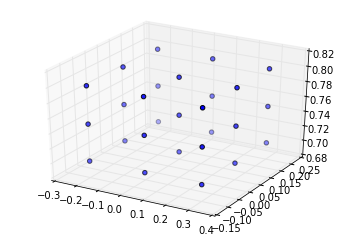

In [20]:
import numpy as np
n = 3j
X, Y, Z = np.mgrid[s_mins[0] + 0.1: s_maxs[0]:n - 0.1, 
                      s_mins[1] + 0.1: s_maxs[1]:n - 0.1, 
                      s_mins[2] + 0.1: s_maxs[2]:n - 0.1]

dense_testcase = np.column_stack((X.flat, Y.flat, Z.flat))

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(X, Y, Z)

xp.evaluate_at([1, 10, 25, 50, 75], dense_testcase)

On teste sur relativement peu d'expériences, on souhaite essentiellement que le robot soit capable de bouger le cube, même si ce n'est pas exactement à la position demandée. En effet certaines positions ne sont certainement pas atteignables et seule une expérience pourra aider à déterminer la véritable zone atteignable.

Par ailleurs, les précédents TP ont montré que les déplacements précis demande dans tous les cas beaucoup d'expériences.

## Exploration
On utilise l'agent crée pour collecter les données.

In [21]:
xp.run()

 (More WARNING ...)



(Les Bootstraped warnings ont été condensées pour plus de clareté.)

## Résultats

On peut commencer par s'informer de l'expérience.

Dans un premier temps on regarde la courbe de progression.

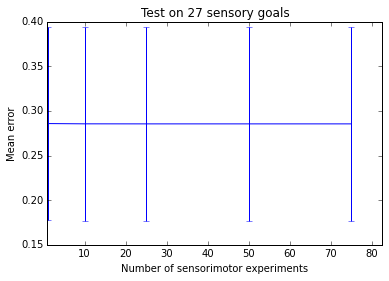

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

ax = plt.subplot(111)
xp.log.plot_learning_curve(ax)

La courbe est plate car les points choisis pour le testcase sont inatteignables, aucun progrès ne peut donc être fait. Il faudrait redéfinir la zone pour voir les progrès effectifs.
Puis, on peut observer les cibles que s'est fixées l'agent contre celles effectivement atteintes.

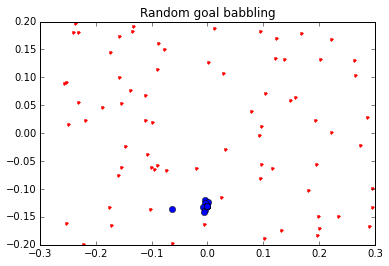

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)
plt.title(('Random goal babbling'))

xp.log.scatter_plot(ax, (('sensori', [0, 1]),))
xp.log.scatter_plot(ax, (('choice', [0, 1]),), marker='.', color='red')

On constate que les points atteints sont très concentré. Vraisemblablement, cela provient d'un espace atteignable réduit par rapport à celui qui a été proposé.

In [24]:
# Saving
import pickle

with open('simu-training.im', 'w') as f: 
    pickle.dump(im_model, f)
    
with open('simu-training.sm', 'w') as f:
    pickle.dump(sm_model, f)

In [25]:
import pypot
pypot.vrep.close_all_connections()

## Utilisation du modèle

À partir du modèle de l'étape on peut donc réaliser notre test. Le robot peut-il placer le cube où on le souhaite ?

Pour le vérifier, repartons de la scène avec le cube et du modèle enregistré.

In [26]:
import pickle

from explauto import SensorimotorModel

with open('simu-training.sm') as f:
    sm_model = pickle.load(f)
    
from poppy.creatures import PoppyTorso
torso = PoppyTorso(simulator='vrep', scene='torso_cube.ttt')

On définit la fonction goto qui devra, en utilisant le modèle inverse, placer le cube à la bonne position.

In [27]:
import time
def goto(pos, duration=2.0):
    m_ag = sm_model.inverse_prediction(pos)
    m_env = env.compute_motor_command(m_ag)
    
    env.move_duration = duration
    env.compute_sensori_effect(m_env)
    time.sleep(duration)

On repart de l'espace atteignable hypothétique (s_mins et s_maxs) pour atteindre des points sur la grille engendrée. On stocke les positions finales du cube.

In [34]:
import numpy
Xe = []
Ye = []
io = torso._controllers[0].io # Interface du robot Torso
for x in numpy.arange(s_mins[0], s_maxs[0], .1):
    for y in numpy.arange(s_mins[1], s_maxs[1], .1):
        for z in numpy.arange(s_mins[2], s_maxs[2], .1):
            torso.reset_simulation()
            goto((x, y, z))
            pos = io.get_object_position('cube')
            Xe.append(pos[0])
            Ye.append(pos[1])
            #print("Goal is (" + str(x) + "," + str(y) + "," + str(z) + ") --> (" + str(pos[0]) + "," + str(pos[1]) + "," + str(pos[2]) + ")")

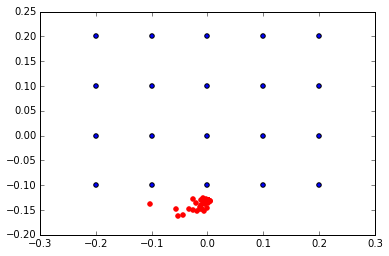

In [36]:
import numpy as np
n = 3j
X, Y = np.mgrid[s_mins[0] + 0.1: s_maxs[0]:0.1, 
                s_mins[1] + 0.1: s_maxs[1]:0.1]

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X, Y)
ax.scatter(Xe, Ye, color='red')

Les points rouges indiquent les positions finales du cube. On voit que le robot est capable de le déplacer.
Quelques images durant l'exécution:

<img src="torso1.png"><img src="torso2.png"><img src="torso3.png"><img src="torso4.png"><img src="torso5.png">

Torso arrive donc bien à toucher le cube et à le déplacer. On voit cependant que le cube se déplace peu dans le plan qui lui est proposé et n'atteint pas les positions demandées. Une amélioration pour l'expérience serait donc de redéfinir la zone atteignable du cube.

On voit également que le robot arrive à déplacer le robot sur sa droite avec son bras gauche (cela parrait normal, il suffit de le pousser) mais aussi légèrement sur la droite (voir 3ème image). Par les mouvements de son bras gauche il arrive à se tourner pour que sa main droite touche le cube. Ce genre de comportement est permis par le modèle sensori-moteur qui s'interrêsse au mouvement du cube et non du bras gauche. Le résultat prime sur le moyen.

# Conclusion

Grâce à Explauto il est donc simple de déterminer un set d'expériences pour entraîner le robot Poppy. Durant le TP, le principal obstacle a été de choisir les paramètres : modèle sensori-moteur ? modèle d'intérêt ? espace atteignable ?

La solution proposée ici a été choisie pour ça rapidité (seulement 75 expériences) pour le résultat (pousser le cube dans un sens ou un autre).